## Challenge Description

Now we'll perform a sentiment analysis, classifying whether feedback left on a website is either positive or negative.

When you're satisfied with its performance (at this point just using the accuracy measure shown in the example), test it on one of the other datasets to see how well these kinds of classifiers translate from one context to another.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.naive_bayes import BernoulliNB
import itertools
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)

In [3]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
data_amazon = "amazon_cells_labelled.txt"
amazon_raw = pd.read_csv(data_amazon, sep='\t', header=None)
amazon_raw.columns = ['sentence', 'score']

In [5]:
amazon_raw.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


I first gather a dictionary of every possible word in the sentences of the amazon reviews to get an idea of what is available for features.

In [6]:
#https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
word_dict = {}
punc_trans = str.maketrans('', '', string.punctuation)
num_trans = str.maketrans('', '', string.digits)
for sentence in amazon_raw['sentence']:
    words = [word.lower() \
             .translate(punc_trans) \
             .translate(num_trans) \
             .strip()
             for word in sentence.split(' ')]
    for word in words:
        word_dict[word] = word_dict.get(word, 0) + 1

In [72]:
word_series = pd.Series(word_dict)
word_series

                 128
a                218
abhor              1
ability            2
able               4
abound             1
about             18
above              2
abovepretty        1
absolutel          1
absolutely         4
ac                 1
accept             2
acceptable         1
access             2
accessable         1
accessing          1
accessory          1
accessoryone       1
accidentally       2
accompanied        1
according          1
activate           1
activated          1
activesync         1
actually           4
ad                 1
adapter            1
adapters           1
add                1
addition           1
additional         2
address            1
adhesive           1
adorable           2
advertised         2
advise             2
after             27
again             12
against            1
aggravating        1
ago                4
alarm              1
all               41
allot              1
allow              1
allowing           1
allows       

In [15]:
occur_enough = word_series.sort_values(ascending=False)/word_series.sum() > .002

I think set up a few different keyword lists as features. The first was what I thought were most obvious, the second includes a few that occur often enough and might have interesting implications, and the last is to be used in greedy tuning to let the model decide for itself what it wants to use.

In [22]:
keywords = ['great', 'good', 'quality', 'recommend', 'excellent',
           'best', 'like', 'nice']
stretch_keys = ['great', 'good', 'quality', 'recommend', 'excellent',
           'best', 'service', 'price', 'like', 'nice', 'works', 'work',
               'dont', 'price', 'really', 'service']
all_words = list(word_series.drop('').index)

for key in all_words:
    amazon_raw[str(key)] = amazon_raw.sentence.str.contains(
        ' ' + str(key) + ' ',
        case=False)

In [23]:
amazon_raw['score'] = (amazon_raw['score'] == 1)

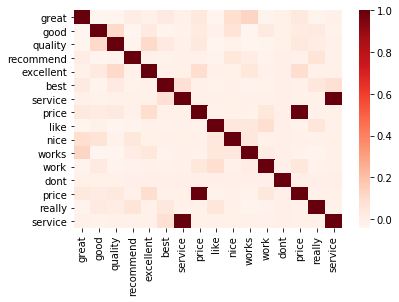

In [24]:
sns.heatmap(amazon_raw[stretch_keys].corr(), cmap="Reds")

Below I define a "greedy tuning" workflow, which works by starting with an empty list of words for features. It then iterates over the keywords, tries each one in turn, and adds the word as a feature to be used in the final model that ends up reducing the error rate the most. This process is continued until no successive word improves the model any further. Note that this is done with a train/test split.  

In [65]:
target = amazon_raw['score']

def greedy_tuning(start_error_rate, keys, cap=None):
    if cap == None:
        cap = (len(keys))
    bnb_best = None   
    best_error_rate = start_error_rate
    greedy_list = []
    best_error_rate = 1000
    test_keys = keys.copy()
    for i in range(cap):
        best_add = None
        #print(i)
        for keyword in test_keys:
            test_list = greedy_list.copy()
            test_list.append(keyword)
            data = amazon_raw[test_list]
            X_train, X_test, y_train, y_test = train_test_split(
                data, target, test_size=0.2, random_state=42)
            bnb = BernoulliNB()
            bnb.fit(X_train, y_train)
            y_pred = bnb.predict(X_test)
            error_rate = (y_test != y_pred).sum()
            if error_rate < best_error_rate:
                best_add, best_error_rate = keyword, error_rate
                bnb_best = bnb
                #print(best_error_rate)
        if best_add == None:
            break
        else:
            test_keys.remove(best_add)
            greedy_list.append(best_add)
    print(greedy_list, best_error_rate/len(y_test))
    return greedy_list, bnb_best

We then apply this greedy tuning algorithm to various lists of words, the first two being hand chosen and the final two ranging over all possible words ever found in a sentence.

In [66]:
greedy_list_min, bnb_min = greedy_tuning(1000, keywords)
greedy_list_med, bnb_med = greedy_tuning(1000, stretch_keys)
greedy_list_all, bnb_all = greedy_tuning(1000, all_words)
greedy_list_cap, bnb_cap = greedy_tuning(1000, all_words, cap=10)

['good', 'quality', 'recommend', 'excellent', 'best', 'great'] 0.405
['good', 'works', 'quality', 'recommend', 'price', 'best'] 0.355
['not', 'get', 'buy', 'me', 'right', 'do', 'last', 'return', 'service', 'terrible', 'too', 'ask', 'bad', 'cannot'] 0.255
['not', 'get', 'buy', 'me', 'right', 'do', 'last', 'return', 'service', 'terrible'] 0.28


Perhaps unexpectedly, the greedy tuning that finds the best model was entirely without human intervention in the initially crafted set of lists. We then end up with the entirely greedy tuned list of keywords having the best predictive power. 

We now try to apply the classifier to the yelp dataset, to see how well the classifier works on a new dataset without any extra training.

In [46]:
data_yelp = "yelp_labelled.txt"
yelp_raw = pd.read_csv(data_yelp, sep='\t', header=None)
yelp_raw.columns = ['sentence', 'score']
yelp_raw.head()

,sentence,score
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [52]:
for key in all_words:
    yelp_raw[str(key)] = yelp_raw.sentence.str.contains(
        ' ' + str(key) + ' ',
        case=False)

yelp_raw['score'] = (yelp_raw['score'] == 1)

In [70]:
yelp_target = yelp_raw['score']

y_pred_min = bnb_min.predict(yelp_raw[greedy_list_min])
error_rate_min = (yelp_target != y_pred_min).sum()
print(error_rate_min/len(yelp_target))

y_pred_med = bnb_med.predict(yelp_raw[greedy_list_med])
error_rate_med = (yelp_target != y_pred_med).sum()
print(error_rate_med/len(yelp_target))

y_pred_all = bnb_all.predict(yelp_raw[greedy_list_all])
error_rate_all = (yelp_target != y_pred_all).sum()
print(error_rate_all/len(yelp_target))

y_pred_cap = bnb_cap.predict(yelp_raw[greedy_list_cap])
error_rate_cap = (yelp_target != y_pred_cap).sum()
print(error_rate_cap/len(yelp_target))

0.419
0.461
0.413
0.421


And I'm actually really surprised that the greedy tuned list on all words of the amazon lists works the best here as well. I assumed it would overfit to the amazon data, but I guess there's more universal properties of reviews than I initially thought.